# Constrained optimization : convex methods and other approaches

## Resources

Machine learning and optimization:
https://towardsdatascience.com/a-quick-overview-of-optimization-models-for-machine-learning-and-statistics-38e3a7d13138

Convex functions : https://www.youtube.com/watch?v=7QmGj1_i3MU

*Hands on Machine Learning ...*, Chapter 4 : Gradient Descent : https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

CVXPY documentation:
https://www.cvxpy.org/

The knapsack problem : 
https://en.wikipedia.org/wiki/Knapsack_problem

NP-Hardness :
https://en.wikipedia.org/wiki/NP-hardness

CVXPY advanced functionalities for integer problems :
https://www.cvxpy.org/tutorial/constraints/index.html

Penalty method : https://en.wikipedia.org/wiki/Penalty_method

Keras regularizers documentation:
https://keras.io/api/layers/regularizers/

Keras constraints documentation:
https://keras.io/api/layers/constraints/


------------------------------------------------
------------------------------------------------

**More about Convex Optimization:**

Stephen Boyd's MOOC:
https://www.edx.org/course/convex-optimization

Stephen Boyd's book:
https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf




In [59]:
import numpy as np
import pandas as pd
import cvxpy as cp

# Part 1 : Convex constrained optimization

Sometimes when adressing a practical data science problem, you might be asked to produce a model that respect some constraints. For example produce a linear regression, but only with positive coefficients because it doesn't make sense to have negative coefficients for the problem you are adressing. 

As you know by now, most of machine learning consists in minimizing an error function. Minimizing a function is the definition of an applied mathematics field : *optimization*. Thus most of machine learning actually is optimization, you can read more about this here:

https://towardsdatascience.com/a-quick-overview-of-optimization-models-for-machine-learning-and-statistics-38e3a7d13138


The general form of an optimization problem (or program) also allows to impose constraints on the function parameters. It writes:


\begin{array}{cccc}
    \mathrm{minimize} &\;\;&f_0(x)&\;&\\
    \mathrm{subject\ to}&\;\;&f_i(x) \leq 0 &\;& i = 1, \ldots, m\\
    &&h_j(x) = 0 &\;& j = 1, \ldots, p
\end{array}


- $x \in \mathbb{R}^n$ is the optimization variable, or the parameters
- $f_0 : \mathbb{R}^n \to \mathbb{R}$ is the objective or error function
- $f_i : \mathbb{R}^n \to \mathbb{R}$ are the inequality constraint functions
- $h_i : \mathbb{R}^n \to \mathbb{R}$ are the equality constraint functions

The optimal value $p^\star$ of $f_0$ is reached for the parameters $x$ that satisfies all the constraints and minimize $f_0$ : $p^\star = \mathrm{inf}\{ f_0(x) | f_i(x) \leq 0, i = 1, \ldots, m, h_j(x) = 0, j = 1, \ldots, p$ \}. Such optimal value of the parameters $x$ is written $x^\star$.

Sometimes when the constraints are incompatible, there are no solutions and the problem is *infeasible*. Conversely sometimes $p^\star = - \infty $ and the problem is called *unbounded below*.

Not all optimization problems are easy to solve, but a subset of them, called *convex optimization problems*, are. A convex optimization problem follows this form :

\begin{array}{ccccc}
    \mathrm{minimize}&\;\;&f_0(x)&\;&\\
    \mathrm{subject\ to}&\;\;&f_i(x) \leq 0 &\;& i = 1, \ldots, m\\
    &&a_j^T x = b_j &\;& j = 1, \ldots, p
\end{array}

where $f_0, \cdots, f_m$ are convex functions, and equality constraints are affine.

A function is *convex* if the line segment between any two points on the graph of the function lies above the graph between the two points. Seeing it drawn makes it much clearer : https://www.youtube.com/watch?v=7QmGj1_i3MU

Convex optimization problems have the nice property that any locally optimal point is also a globally optimal point $x^\star$, which makes them relatively easy to solve and guarantees that the solution $x^\star$ is among the best ones.

If you don't remember what are local and global optima, re-read the *Gradient descent* part in chapter 4 of *Hands on Machine Learning... * : https://drive.google.com/file/d/1t0rc3x5YQBgLXVLET6BzR4jn5vzMI_m0/view?usp=sharing

Using the CVXPY library, you will learn how to solve such constrained convex problems.

## Linear problems : The diet problem

Let's start with a classic problem called the diet problem. We have:
- $n$ different types of food
- $m$ different types of nutrients
- The food costs $c \in \mathbb{R}^n$
- The matrix of nutrient content for each type of food $A \in \mathbb{R}^{m \times n}$
- The minimum amount of nutrients needed for a human being $b \in \mathbb{R}^m$

We want to minimize the cost in food spendings such that the corresponding diet satisfies all the nutrient needs. In other words, we want to :

$$
\begin{array}{ccc}
    \mathrm{minimize} &\;\;& c^T x\\
    \mathrm{subject\ to}&\;\;&Ax \geq b\\
    &&x \geq 0
\end{array}
$$

The solution $x^\star \in \mathbb{R}^n$ gives us the optimal quantity of each food to buy (and thus cannot be negative).

Let's start easy and forget about the nutrients, skim through CVXPY documentation : https://www.cvxpy.org/ ,
and solve the following problem:


\begin{array}{ccc}
    \mathrm{minimize} &\;\;& c^T x\\
    &&x \geq 0
\end{array}

In [60]:
foods = ["Roasted Chicken", "Spaghetti", "Tomato,Red,Ripe,Raw", "Apple,Raw,W/Skin", 
         "Grapes", "Chocolate Chip Cookies", "Lowfat Milk", "Hotdog"]

food_costs = pd.Series([0.84, 0.78, 0.27, 0.24, 0.32, 0.03, 0.23, 0.31], index = foods)


In [61]:

# optimisation of food consumption based on their price
x = cp.Variable(len(foods))
objective = cp.Minimize(food_costs.to_numpy() @ x)  # numpy !!! 
constraints = [x >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(1.618970705828567e-09)

so that means it is better to not to eat at all ?

No surprises, without nutrient constraints, the optimal solution to minimize the cost is to stop eating ! Now add the $Ax \geq b$ constraint with the following data :

In [62]:
nutrients = ["Calories", "Calcium", "Iron", "Vit_A", "Dietary_Fiber", "Carbohydrates", "Protein"]

food_nutrients = pd.DataFrame([
    (277.4, 21.9, 1.8, 77.4, 0, 0, 42.2),
    (358.2, 80.2, 2.3, 1355.2, 11.6, 58.3, 8.2),
    (25.8, 6.2, 0.6, 766.3, 1.4, 5.7, 1),
    (81.4, 9.7, 0.2, 73.1, 3.7, 21, 0.3),
    (15.1, 3.4, 0.1, 24, 0.2, 4.1, 0.2),
    (78.1, 6.2, 0.4, 0, 0, 24, 0.9),
    (121.2, 296.7, 0.1, 500.2, 0, 11.7, 8.1),
    (242.1, 23.5, 2.3, 0, 0, 18, 10.4) ],
    columns = nutrients,
    index = foods).T

nutrients_min = pd.Series([2000, 800, 10, 10000, 25, 0, 50], index = nutrients)

In [63]:
# optimisation of food consumption based on their price and nutrients
x = cp.Variable(len(foods))
objective = cp.Minimize(food_costs.to_numpy() @ x)
constraints = [x >=0]
for i in range(len(nutrients)):
    constraints.append(food_nutrients.iloc[i].to_numpy() @ x >= nutrients_min.iloc[i])
problem = cp.Problem(objective, constraints)
problem.solve()

np.float64(4.3737229963602715)

In [64]:
print('Optimal food consumption:')
print(pd.Series(np.round(x.value), index = foods))

Optimal food consumption:
Roasted Chicken            0.0
Spaghetti                  1.0
Tomato,Red,Ripe,Raw       10.0
Apple,Raw,W/Skin           0.0
Grapes                     0.0
Chocolate Chip Cookies    14.0
Lowfat Milk                2.0
Hotdog                     0.0
dtype: float64


This doesn't look like a very equilibrated diet, especially regarding carbohydrates, let's add some maximum constraints on nutrients : $Ax \leq d$, where  $d \in \mathbb{R}^m$ is the maximum amount of nutrients :

In [65]:
nutrients_max = pd.Series([3000, 1600, 30, 50000, 100, 250, 100], index = nutrients)

In [66]:
x = cp.Variable(len(foods))
objective = cp.Minimize(food_costs.to_numpy() @ x)
constraints = [x >=0]
for i in range(len(nutrients)):
    constraints.append(food_nutrients.iloc[i].to_numpy() @ x >= nutrients_min.iloc[i])
for i in range(len(nutrients)):
    constraints.append(food_nutrients.iloc[i].to_numpy() @ x <= nutrients_max.iloc[i])
problem = cp.Problem(objective, constraints)
problem.solve()

print('Optimal food consumption:')
print(pd.Series(np.round(x.value), index = foods))

Optimal food consumption:
Roasted Chicken           0.0
Spaghetti                 1.0
Tomato,Red,Ripe,Raw       8.0
Apple,Raw,W/Skin          0.0
Grapes                    0.0
Chocolate Chip Cookies    1.0
Lowfat Milk               5.0
Hotdog                    3.0
dtype: float64


In [67]:
constraints

[Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Constant(CONSTANT, ZERO, ())),
 Inequality(Constant(CONSTANT, NONNEGATIVE, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ())),
 Inequality(Expression(AFFINE, UNKNOWN, ()))]

In [68]:
for c in problem.constraints:
    print("Constraint:", c)
    print("Dual value (if solved):", c.dual_value)

Constraint: 0.0 <= var208
Dual value (if solved): [3.78253770e-01 9.66670695e-10 1.45022019e-10 1.66225712e-01
 3.04640959e-01 1.43002724e-09 2.40075461e-10 4.94405838e-10]
Constraint: 2000.0 <= [277.4 358.2  25.8  81.4  15.1  78.1 121.2 242.1] @ var208
Dual value (if solved): 0.0015949191643314486
Constraint: 800.0 <= [ 21.9  80.2   6.2   9.7   3.4   6.2 296.7  23.5] @ var208
Dual value (if solved): 1.4585311307015386e-12
Constraint: 10.0 <= [1.8 2.3 0.6 0.2 0.1 0.4 0.1 2.3] @ var208
Dual value (if solved): 1.4829447358348623e-10
Constraint: 10000.0 <= [  77.4 1355.2  766.3   73.1   24.     0.   500.2    0. ] @ var208
Dual value (if solved): 0.0003277234566650919
Constraint: 25.0 <= [ 0.  11.6  1.4  3.7  0.2  0.   0.   0. ] @ var208
Dual value (if solved): 0.0010581332099434966
Constraint: 0.0 <= [ 0.  58.3  5.7 21.   4.1 24.  11.7 18. ] @ var208
Dual value (if solved): 3.786464041648382e-12
Constraint: 50.0 <= [42.2  8.2  1.   0.3  0.2  0.9  8.1 10.4] @ var208
Dual value (if solved):

So one can basically live on spaghetti, tomatoes, cookies, milk and hotdogs. Good to know.

## Quadratic problems : Constrained linear regression

Now let's switch to a classic machine learning model : linear regression, but with constraints on the regression coefficients.

In the following example, we have $n$ chemical elements, $m$ minerals, a matrix $A \in \mathbb{R}^{n \times m}$ that gives the chemical composition of each mineral, and the chemical composition of a geological sample $b \in \mathbb{R}^n$. 

From this we want to approximate the mineral composition of the geological sample $x \in \mathbb{R}^m$ with a linear regression. Thus $x$ must contain only non-negative values, and must sum to 1.

Write the corresponding convex problem on paper, and then with CVXPY using the following data:

In [69]:
# 10 Chemical element x 13 mineral type matrix, containing the proportion of each element in each mineral type

mineral_chemical_compositions = np.array([[63.1545, 64.3049, 100., 37.1417, 32.4026, 30.0382, 30.7033, 0., 36.5444, 0., 0., 0., 0.0034],
   [0.0016, 0.01, 0., 0.6641, 2.35946, 26.91, 0., 0., 0.297125, 0., 0., 0., 51.3026], 
   [17.8683, 21.096, 0., 11.2387, 14.3019, 6.46115, 0.34805, 0., 14.368, 0., 0., 0., 0.], 
   [0.0223, 0.1191, 0., 30.6859, 32.0779, 1.5471, 1.5014, 0., 11.5299, 0., 0., 0., 43.3621], 
   [0., 0., 0., 0.94408, 0.6131, 0.0986, 0., 0., 0., 0., 0., 0., 2.1039], 
   [0., 0., 0., 1.14598, 1.82486, 0.03695, 0.00935, 0., 0.2312, 0., 0., 0., 0.0166], 
   [0.625667, 9.77073, 0., 1.35584, 0.0558, 0.05635, 0., 0., 0.079275, 0., 0., 0., 0.018], 
   [0., 2.80603, 0., 10.7388, 0.0245429, 27.7454, 2.19443, 55.08, 10.5478, 56.03, 78.13, 10.44, 0.0262], 
   [15.7365, 0.0874667, 0., 1.89652, 8.54851, 0.00475, 0., 0., 0.09665, 0., 0., 0., 0.0115], 
   [0., 0., 0., 0.16636, 0., 0., 0.0293, 42.4, 0.0114, 0., 0., 0., 0.0617]])

# Proportion of each of the 10 elements analyzed in the geological sample

sample_chemical_composition = np.array([ 65.67, 0.52, 14.77, 5.418, 0.13, 0.3, 3.22, 2.05, 6.07, 0.13 ])

In [70]:
#TOFILL
# Proportion of each of the minerals in the geo sample
x = cp.Variable(mineral_chemical_compositions.shape[1])
objective = cp.Minimize(cp.sum_squares(mineral_chemical_compositions @ x - sample_chemical_composition))

constraints = [x >=0, cp.sum(x) == 1]

problem = cp.Problem(objective, constraints)
problem.solve()

print('Mineral proportion in the sample:')
print(pd.Series(np.round(x.value, 2), index = range(mineral_chemical_compositions.shape[1])))

Mineral proportion in the sample:
0     0.34
1     0.31
2     0.19
3     0.11
4     0.06
5    -0.00
6    -0.00
7    -0.00
8    -0.00
9    -0.00
10   -0.00
11   -0.00
12    0.00
dtype: float64


## Integer problems : the knapsack problem

The knapsack problem is a classic combinatorial optimization problem, where one must maximize the total value of the objects put in the knapsack, without exceeding the knapsack capacity.

Read more about the knapsack problem : https://en.wikipedia.org/wiki/Knapsack_problem

The knapsack problem is called an integer problem as some variable values are constrained to integer values. Here we are going to address the 0-1 knapsack, where we can put only once each object in the knapsack. Problems where variable values are constrained to be 0 or 1 are a subtype of integer problems called boolean problems.

All integer problems are non-convex problems, and we do not know any algorithms to solve them in polynomial time (as they are NP-Hard problems https://en.wikipedia.org/wiki/NP-hardness ).

However CVXPY integrates Mixed-Integer solvers that yields good approximations of such problems in a reasonable time.

Use these functionalities of cvxpy to solve the following 0-1 knapsack problem :
https://www.cvxpy.org/tutorial/constraints/index.html

In [71]:
object_values = np.array([10, 8, 1, 5.5, 3, 12, 2])
object_weights = np.array([5, 3, 0.1, 5, 4, 18, 5])

knapsack_max_weight = 15

In [72]:
#TOFILL
# what object should be taken to maximize the value of the knapsack within the weight limit
x = cp.Variable(len(object_weights), boolean=True)
objective = cp.Maximize(object_values @ x)
constraints = [object_weights @ x <= knapsack_max_weight]

problem = cp.Problem(objective, constraints)
problem.solve()

print('Object to take:')
print(pd.Series(['Yes' if val > 0.5 else 'No' for val in x.value], index=range(len(object_weights))))


Object to take:
0    Yes
1    Yes
2    Yes
3    Yes
4     No
5     No
6     No
dtype: object


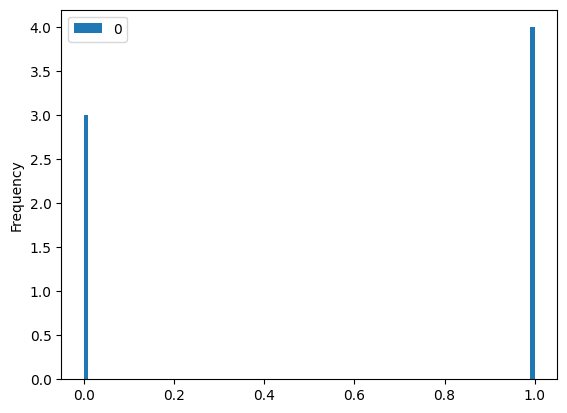

In [73]:
pd.DataFrame(x.value).plot(kind='hist', bins=100);

However, even these solvers become too slow when the problem becomes too big. When a non-convex problem is untractable, a classical technique is to relax its constraints in order to build an approximation of the problem that is convex. This is called a *convex relaxation*.

Propose a convex relaxation of the knapsack problem for the following data, and solve it with cvxpy:

In [74]:
#Creating n random object values and weights between 0 and 10
n = 1000000
scale = 10

object_values = np.array([np.random.random() * scale for i in range(n) ])
object_weights = np.array([np.random.random() * scale for i in range(n) ])

knapsack_max_weight = (n * scale) / 20

In [75]:
knapsack_max_weight

500000.0

In [76]:
object_weights.max()

np.float64(9.999989557434922)

In [77]:
#TOFILL
x = cp.Variable(len(object_weights))
objective = cp.Maximize(object_values @ x)
constraints = [object_weights @ x <= knapsack_max_weight, x >=0, x<= 1]

problem = cp.Problem(objective, constraints)
problem.solve()

print('Object to take:')
print(pd.Series(['Yes' if val > 0.5 else 'No' for val in x.value], index=range(len(object_weights))).iloc[:10])
print(f'Total value: {np.round(object_values @ x.value, 2)}')
print(f'Total weight: {np.round(object_weights @ x.value, 2)}')

KeyboardInterrupt: 

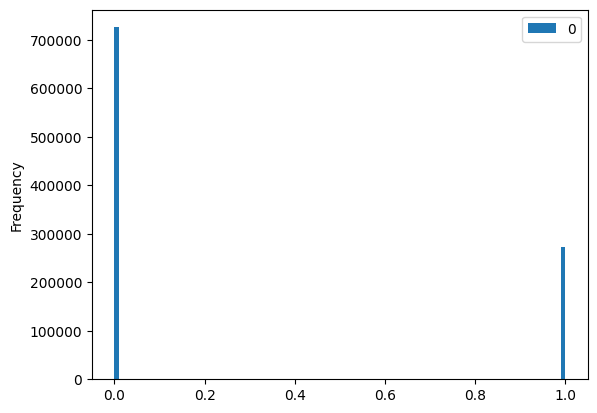

In [8]:
pd.DataFrame(x.value).plot(kind='hist', bins=100);

As you can see, this yields a useful result, even if the original constraints are not exactly satisfied.

However depending on the problem constraint values, sometimes such approximations doesn't give a very useful result.

# [Going further] Re-assigning electricity production units to each production plant

In this problem you have $k$ electricity production plants, in which there are a total of $n_o$ production units, and for each of them you have its production history as a time series of length *m*. Unfortunately, you don't know which unit belongs to which plant, and some units production history are missing (you only have $n$ units history available), but you know the total production history of each plant. Given these informations, re-assign each unit to its production plant. When you're done try to change the number of plants and the missing ratio to see how far your solution correctly works.

In [2]:
#Problem generation :

# Number of electricity production units
n_o = 100 
# Number of time steps
m = 5000
# Number of electricity production plants
k = 3
# Ratio of missing production units data
missing_ratio = 0.50

#Production history for each production unit 
unit_productions = np.random.random((n_o,m)) * 10

#Ground truth affectation of each production unit to a production plant
affectations = np.random.choice(k, n_o)

# Number of available production units data
n = int(n_o*(1-missing_ratio)) 

#Available production units 
available_units_indexes = np.random.choice(n_o, n, replace=False)
available_units_affectation = affectations[available_units_indexes]
#Available data :

#Total production of each plant
total_productions = np.vstack( 
    [ unit_productions[affectations == i].sum(axis=0) for i in range(k) ])

#Available production units data
unit_productions_available = unit_productions[available_units_indexes]

#Goal try to find back in which plant is each production unit only from available data,
#i.e. try to find back the `available_units_affectation` array 

In [68]:
unit_productions_available.T.shape, total_productions.T.shape

((5000, 50), (5000, 3))

In [3]:
unit_productions_available = unit_productions_available / np.linalg.norm(unit_productions_available)
total_productions = total_productions / np.linalg.norm(total_productions)

In [ ]:
# Try to find back in which plant is each production unit only from available data
x = cp.Variable((n, k))
objective = cp.Minimize(cp.sum_squares(unit_productions_available.T @ x - total_productions.T))
constraints = [x >= 0, cp.sum(x, axis=1) == 1]
problem = cp.Problem(objective, constraints)
problem.solve()

6.6511115616404615

In [21]:
print('affectations calculated:')
pd.DataFrame(x.value, columns = ['Plant 1', 'Plant 2', 'Plant 3']).map(lambda x: 1 if x > 1 / k else 0).head()

affectations calculated:


,Plant 1,Plant 2,Plant 3
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,0,1


In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
real = encoder.fit_transform(available_units_affectation.reshape(-1,1))
pd.DataFrame(real.astype(int), columns=['Plant 1', 'Plant 2', 'Plant 3']).head()

,Plant 1,Plant 2,Plant 3
0,0,1,0
1,0,1,0
2,1,0,0
3,1,0,0
4,0,0,1


What is the link between this problem and the knapsack problem ?

# Part 2 : Other constrained optimization methods

Sometimes when a constrained problem is not convex, or when it is to big to be solved with a convex solver, it can be useful to turn to other techniques to approximately enforce these constraints, such as using penalty functions, or projected gradient descent.

## Constrained linear regression (again)

In the following and to keep a continuity in the course, we will continue with our constrained linear regression problem to approximate the mineral composition of a geological sample, even if in this case, using a convex solver should be preferred as it is a convex problem !

### Replacing constraints with penalties

The first method consists in adding penalties to the error function $f_0$ that correspond to the constraints.

Read https://en.wikipedia.org/wiki/Penalty_method
 
In our case we will use linear penalties to replace :
- inequality constraints $f_i(x) \leq 0 $ by adding in the objective function : $ + \lambda\;\max(0,f_i(x))$
- equality constraints $h_j(x) = 0 $ by adding in the objective function : $ + \lambda |h_j(x)| $

where $\lambda \in \mathbb{R}$ is a new hyperparameter of the model, and controls the importance of the constraints relatively to the original objective function $f_0$.

Hence when replacing constraints with linear penalties the problem becomes :



$$\mathrm{minimize} \;\; f_0(x) + \lambda(\max(0,f_i(x)) + |h_j(x)|)$$


First write on paper the corresponding optimization problem when replacing constraints with such penalties for the constrained linear regression problem of the geological sample composition seen before.

To implement this penalized version of the constrained linear regression problem, we will use Keras. Implement first a classic linear regression with Keras without any penalty (and don't forget to not fit the intercept, as we don't want it in our geological example !) :

In [78]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import *
from keras import losses
from keras.regularizers import Regularizer
import keras.ops as K
from keras import metrics

In [82]:
A = mineral_chemical_compositions
b = sample_chemical_composition

In [83]:
def linear_regression_model(input_dim):
    """
    Input : 
    input_dim : int : Number of features of the linear regression
    
    Output : 
    model : keras.Model : the keras Model object
    regression_layer : keras.layers.Layer : the keras Layer object 
                        that contains the linear regression coefficients
                        
    """

    regression_layer = layers.Dense(1, use_bias=False)
    inputs = keras.Input(shape=(input_dim,))
    outputs = regression_layer(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    # def penalized_loss(y_true, y_pred):

    #     loss = keras.losses.mean_squared_error(y_true, y_pred)
    #     # Non-negativity penalty: max(0, -xi)
    #     penalty1 = K.sum(K.maximum(0, -regression_layer.kernel)) #weights as regression_layer
    #     # Sum-to-one penalty
    #     penalty2 = K.sum(K.maximum(0, K.sum(regression_layer.kernel)-1))

    #     return loss + lambda1*penalty1 + lambda2*penalty2

    return model, regression_layer



In [84]:
max_epochs = 2000
batch_size = 10

model, regression_layer = linear_regression_model(A.shape[1])
model.fit(A, b, epochs=max_epochs, batch_size=batch_size, verbose=2)

Epoch 1/2000
1/1 - 0s - 285ms/step - loss: 2764.8013 - mse: 2764.8013
Epoch 2/2000
1/1 - 0s - 28ms/step - loss: 2751.1450 - mse: 2751.1450
Epoch 3/2000
1/1 - 0s - 27ms/step - loss: 2737.5359 - mse: 2737.5359
Epoch 4/2000
1/1 - 0s - 29ms/step - loss: 2723.9756 - mse: 2723.9756
Epoch 5/2000
1/1 - 0s - 30ms/step - loss: 2710.4644 - mse: 2710.4644
Epoch 6/2000
1/1 - 0s - 32ms/step - loss: 2697.0029 - mse: 2697.0029
Epoch 7/2000
1/1 - 0s - 32ms/step - loss: 2683.5913 - mse: 2683.5913
Epoch 8/2000
1/1 - 0s - 31ms/step - loss: 2670.2307 - mse: 2670.2307
Epoch 9/2000
1/1 - 0s - 31ms/step - loss: 2656.9221 - mse: 2656.9221
Epoch 10/2000
1/1 - 0s - 32ms/step - loss: 2643.6646 - mse: 2643.6646
Epoch 11/2000
1/1 - 0s - 32ms/step - loss: 2630.4590 - mse: 2630.4590
Epoch 12/2000
1/1 - 0s - 30ms/step - loss: 2617.3052 - mse: 2617.3052
Epoch 13/2000
1/1 - 0s - 30ms/step - loss: 2604.2034 - mse: 2604.2034
Epoch 14/2000
1/1 - 0s - 29ms/step - loss: 2591.1548 - mse: 2591.1548
Epoch 15/2000
1/1 - 0s - 31m

In [85]:
regression_layer.get_weights()

[array([[ 0.29891574],
        [ 0.12553032],
        [ 0.34481254],
        [ 0.29663077],
        [ 0.04583663],
        [-0.00844738],
        [-0.23609817],
        [ 0.00206106],
        [-0.01226528],
        [-0.55405873],
        [ 0.4004756 ],
        [-0.0922024 ],
        [-0.04013505]], dtype=float32)]

As we can see, our desired constraints (the coefficients $x \in \mathbb{R}^n$ must be only non-negative values, and must sum to 1) are not naturally respected.

Let's first add the value constraints : $ x \geq 0$ and $x \leq 1$, by adding the corresponding penalties : $\lambda\;\sum_i\max(0, -x_i + 0)$ and $\lambda\;\sum_i\max(0,x_i - 1 )$.

To do so we will use a custom layer weight regularizer.
Learn about layer regularizers : https://keras.io/api/layers/regularizers/


Let's code a regularizer that add penalties for any minimum and maximum values and not just 0 and 1.
Complete the following code to add the corresponding penalties to the layer weights :

In [86]:
class LinearBoxPenalties(Regularizer):

    def __init__(self, lambda_, min_value, max_value):
        
        self.lambda_ = lambda_
        self.min_value = min_value
        self.max_value = max_value
        
    def get_config(self):
        return {'lambda': self.lambda_, 'min_value' : self.min_value, 'max_value' : self.max_value}

    def __call__(self, x):

        #TOFILL:
        penalty1 = K.sum(K.maximum(0, self.min_value -x))
        penalty2 = K.sum(K.maximum(0, x - self.max_value ))
        #penalty2 = K.abs(K.sum(x) - self.max_value)

        return self.lambda_ * (penalty1 + penalty2) 

And rewrite your linear regression so that it takes into account your penalty :

In [123]:
def linear_regression_model_with_penalty_cstrs(input_dim, regularizer):
    """
    Input : 
    input_dim : int : Number of features of the linear regression
    regularizer : keras.regularizers.Regularizer : The regularizer object to add to linear regression coefficients
    
    Output : 
    model : keras.Model : the keras Model object
    regression_layer : keras.layers.Layer : the keras Layer object 
                        that contains the linear regression coefficients
                        
    """
    inputs = keras.Input(shape=(input_dim,))
    
    regression_layer = keras.layers.Dense(1,
        use_bias=False,
        kernel_regularizer=regularizer
    )
    
    outputs = regression_layer(inputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='RMSProp', loss='mse', metrics=['mse'])

    
    return model, regression_layer

Now retrain your linear regression with your penalty and compare the obtained coefficients with ones you obtained with cvxpy :

In [88]:
penalty_regularizer = LinearBoxPenalties(lambda_ = 10, min_value = 0, max_value = 1)

model, regression_layer = linear_regression_model_with_penalty_cstrs(A.shape[1], penalty_regularizer)

model.fit(A,b, epochs = max_epochs, batch_size = batch_size, verbose = 2)

Epoch 1/2000
1/1 - 0s - 263ms/step - loss: 1408.5828
Epoch 2/2000
1/1 - 0s - 28ms/step - loss: 1397.5599
Epoch 3/2000
1/1 - 0s - 29ms/step - loss: 1386.5886
Epoch 4/2000
1/1 - 0s - 31ms/step - loss: 1375.6698
Epoch 5/2000
1/1 - 0s - 30ms/step - loss: 1364.8046
Epoch 6/2000
1/1 - 0s - 30ms/step - loss: 1353.9929
Epoch 7/2000
1/1 - 0s - 31ms/step - loss: 1343.2404
Epoch 8/2000
1/1 - 0s - 30ms/step - loss: 1332.5500
Epoch 9/2000
1/1 - 0s - 28ms/step - loss: 1321.9163
Epoch 10/2000
1/1 - 0s - 30ms/step - loss: 1311.3402
Epoch 11/2000
1/1 - 0s - 30ms/step - loss: 1300.8225
Epoch 12/2000
1/1 - 0s - 29ms/step - loss: 1290.3630
Epoch 13/2000
1/1 - 0s - 30ms/step - loss: 1279.9630
Epoch 14/2000
1/1 - 0s - 30ms/step - loss: 1269.6229
Epoch 15/2000
1/1 - 0s - 30ms/step - loss: 1259.3435
Epoch 16/2000
1/1 - 0s - 31ms/step - loss: 1249.1246
Epoch 17/2000
1/1 - 0s - 30ms/step - loss: 1238.9674
Epoch 18/2000
1/1 - 0s - 27ms/step - loss: 1228.8722
Epoch 19/2000
1/1 - 0s - 29ms/step - loss: 1218.8392
E

We can see that the min and max constraints are well satisfied, however the coefficient still doesn't sum to one. 

Complete the following code to add both a min and max values penalties, as well as the sum penalty $ \lambda |\sum_i(x_i) - 1|$ :

In [89]:
class LinearBoxAndSumPenalties(Regularizer):

    def __init__(self, lambda_, min_value, max_value, sum_value):
        self.lambda_ = lambda_
        self.min_value = min_value
        self.max_value = max_value
        self.sum_value = sum_value
        
    def get_config(self):
        return {'lambda': self.lambda_, 'min_value' : self.min_value, 
                'max_value' : self.max_value, 'sum_value' : self.sum_value }
    

    def __call__(self, x):
        #TOFILL
        penalty1 = K.sum(K.maximum(0, self.min_value - x))
        penalty2 = K.sum(K.maximum(0, x - self.max_value ))
        penalty3 = K.abs(K.sum(x) - self.sum_value)
        return self.lambda_ * (penalty1 + penalty2 + penalty3)

In [140]:
for l in [0.1, 1, 10, 100, 1000, 10000]:
    print(f'lambda = {l}')
    penalty_regularizer = LinearBoxAndSumPenalties(lambda_ = l, min_value = 0, max_value = 1, sum_value = 1)
    model, regression_layer = linear_regression_model_with_penalty_cstrs(A.shape[1], penalty_regularizer)
    history = model.fit(A,b, epochs=max_epochs, batch_size=batch_size, verbose = 0)
    print(f"Final loss = {np.round(history.history['mse'][-1], 2)}")
    print(pd.Series(np.round(regression_layer.get_weights(),2).reshape(-1)))

# penalty_regularizer = LinearBoxAndSumPenalties(lambda_ = 10, min_value = 0, max_value = 1, sum_value = 1)
# model, regression_layer = linear_regression_model_with_penalty_cstrs(A.shape[1], penalty_regularizer)
# history = model.fit(A,b, epochs=max_epochs, batch_size=batch_size, validation_data=(A,b), verbose = 0)

lambda = 0.1
Final loss = 0.02
0     0.21
1     0.30
2     0.15
3     0.05
4     0.30
5     0.21
6     0.14
7     0.00
8    -0.12
9    -0.22
10    0.10
11   -0.00
12   -0.12
dtype: float32
lambda = 1
Final loss = 0.04
0     0.33
1     0.31
2     0.19
3     0.08
4     0.09
5     0.01
6    -0.00
7     0.00
8     0.00
9    -0.00
10   -0.00
11   -0.00
12    0.00
dtype: float32
lambda = 10
Final loss = 0.01
0     0.31
1     0.32
2     0.20
3     0.04
4     0.13
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.01
11    0.00
12    0.00
dtype: float32
lambda = 100
Final loss = 0.05
0     0.27
1     0.33
2     0.22
3     0.00
4     0.17
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.01
11    0.00
12    0.00
dtype: float32
lambda = 1000
Final loss = 17.66
0     0.06
1     0.05
2     0.48
3     0.02
4     0.04
5     0.00
6     0.24
7     0.00
8     0.01
9     0.00
10    0.00
11    0.10
12    0.00
dtype: float32
lambda = 10000
Final loss = 288.26
0     0.05
1     0.05

In [141]:
for l in [5, 10, 20, 30, 50]:
    print(f'lambda = {l}')
    penalty_regularizer = LinearBoxAndSumPenalties(lambda_ = l, min_value = 0, max_value = 1, sum_value = 1)
    model, regression_layer = linear_regression_model_with_penalty_cstrs(A.shape[1], penalty_regularizer)
    history = model.fit(A,b, epochs=max_epochs, batch_size=batch_size, verbose = 0)
    print(f"Final loss = {np.round(history.history['mse'][-1], 2)}")
    print(pd.Series(np.round(regression_layer.get_weights(),2).reshape(-1)))

lambda = 5
Final loss = 0.01
0     0.33
1     0.30
2     0.19
3     0.08
4     0.08
5    -0.00
6    -0.00
7     0.00
8     0.01
9     0.00
10    0.00
11   -0.00
12    0.00
dtype: float32
lambda = 10
Final loss = 0.01
0     0.29
1     0.33
2     0.21
3     0.00
4     0.16
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.01
11    0.00
12    0.00
dtype: float32
lambda = 20
Final loss = 0.01
0     0.31
1     0.32
2     0.20
3     0.05
4     0.11
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32
lambda = 30
Final loss = 0.47
0     0.35
1     0.17
2     0.23
3     0.01
4     0.06
5     0.00
6     0.00
7    -0.00
8     0.19
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32
lambda = 50
Final loss = 0.04
0     0.28
1     0.33
2     0.21
3     0.00
4     0.17
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.01
11    0.00
12    0.00
dtype: float32


In [144]:
for l in [7, 7.5, 8, 8.5, 9]:
    print(f'lambda = {l}')
    penalty_regularizer = LinearBoxAndSumPenalties(lambda_ = l, min_value = 0, max_value = 1, sum_value = 1)
    model, regression_layer = linear_regression_model_with_penalty_cstrs(A.shape[1], penalty_regularizer)
    history = model.fit(A,b, epochs=max_epochs, batch_size=batch_size, verbose = 0)
    print(f"Final loss = {np.round(history.history['mse'][-1], 4)}")
    print(pd.Series(np.round(regression_layer.get_weights(),2).reshape(-1)))

lambda = 7
Final loss = 0.0299
0     0.35
1     0.30
2     0.19
3     0.11
4     0.05
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32
lambda = 7.5
Final loss = 0.0153
0     0.32
1     0.31
2     0.19
3     0.06
4     0.10
5     0.00
6    -0.00
7     0.00
8     0.00
9    -0.00
10    0.00
11   -0.00
12    0.00
dtype: float32
lambda = 8
Final loss = 0.0425
0     0.32
1     0.31
2     0.19
3     0.07
4     0.10
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32
lambda = 8.5
Final loss = 0.0107
0     0.32
1     0.29
2     0.20
3     0.04
4     0.11
5     0.00
6     0.00
7     0.00
8     0.05
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32
lambda = 9
Final loss = 0.0145
0     0.34
1     0.30
2     0.18
3     0.11
4     0.05
5     0.00
6    -0.00
7     0.00
8    -0.00
9    -0.00
10   -0.00
11   -0.00
12    0.00
dtype: float32


Play with lambda and see how it changes the obtained $x$ values compared to the result of the convex approach.

### Enforcing constraints with projected gradient descent

The other main method to use constraints with problems that cannot be solved by convex solvers is called *projected gradient descent*. The idea is pretty simple, we only $\mathrm{minimize}\;f_0(x)$ with gradient descent, and after each gradient update, we have a look at the parameters, if they do not respect the constraints, then we modify them so that they respect the constraints. In other words we project the parameters values on the surface of the parameter-values set that respect the constraints.

In our case that means that if any coefficient in $x$ is below 0, we replace it by zero ; if any coefficient in $x$ is above 1, we replace it by one ; and if $x$ doesn't sum to 1, we rescale all the coefficients in $x$ so that they do.

Again we can do this in Keras, with the layer weights constraints : https://keras.io/api/layers/constraints/

Let's code a constraint that replaces the layer wieghts below a minimum value by this value, and above a maximum value by this other value.

Complete the following code to add these projection steps to your layer weights :

In [151]:
from keras.constraints import Constraint

class ProjectedBoxConstraint(Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value
        
    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value}
    
    def __call__(self, x):
        #TOFILL
        x = K.clip(x, self.min_value, self.max_value)
        # x = x / K.sum(x)
        return x 
    

In [173]:
def linear_regression_model_with_projected_cstrs(input_dim, cstr):
    """
    Input : 
    input_dim : int : Number of features of the linear regression
    cstr : keras.constraints.Constraint : the keras Constraint object 
                        that contains the projection operations to satisfy the constraints
    
    Output : 
    model : keras.Model : the keras Model object
    regression_layer : keras.layers.Layer : the keras Layer object 
                        that contains the linear regression coefficients
                        
    """
    #TOFILL
    inputs = keras.Input(shape=(input_dim,))

    regression_layer = keras.layers.Dense(
        1,
        use_bias=False,
        kernel_constraint=cstr
    )

    outputs = regression_layer(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='RMSProp', loss='mse', metrics=['mse'])
    
    return model, regression_layer

In [153]:
projected_constraint = ProjectedBoxConstraint(min_value = 0, max_value = 1)

model, regression_layer = linear_regression_model_with_projected_cstrs(A.shape[1], projected_constraint)

model.fit(A,b, epochs=max_epochs, batch_size=batch_size, verbose = 2)

Epoch 1/2000


1/1 - 0s - 242ms/step - loss: 1088.6335 - mse: 1088.6335
Epoch 2/2000
1/1 - 0s - 29ms/step - loss: 102.3431 - mse: 102.3431
Epoch 3/2000
1/1 - 0s - 30ms/step - loss: 100.7595 - mse: 100.7595
Epoch 4/2000
1/1 - 0s - 30ms/step - loss: 99.4688 - mse: 99.4688
Epoch 5/2000
1/1 - 0s - 29ms/step - loss: 98.3151 - mse: 98.3151
Epoch 6/2000
1/1 - 0s - 29ms/step - loss: 97.2426 - mse: 97.2426
Epoch 7/2000
1/1 - 0s - 28ms/step - loss: 96.2242 - mse: 96.2242
Epoch 8/2000
1/1 - 0s - 31ms/step - loss: 95.2447 - mse: 95.2447
Epoch 9/2000
1/1 - 0s - 29ms/step - loss: 94.2944 - mse: 94.2944
Epoch 10/2000
1/1 - 0s - 33ms/step - loss: 93.3672 - mse: 93.3672
Epoch 11/2000
1/1 - 0s - 32ms/step - loss: 92.4588 - mse: 92.4588
Epoch 12/2000
1/1 - 0s - 29ms/step - loss: 91.5662 - mse: 91.5662
Epoch 13/2000
1/1 - 0s - 29ms/step - loss: 90.6875 - mse: 90.6875
Epoch 14/2000
1/1 - 0s - 29ms/step - loss: 89.8210 - mse: 89.8210
Epoch 15/2000
1/1 - 0s - 30ms/step - loss: 88.9659 - mse: 88.9659
Epoch 16/2000
1/1 - 0s 

In [154]:
print(pd.Series(np.round(regression_layer.get_weights(),2).reshape(-1)))

0     0.31
1     0.30
2     0.20
3     0.01
4     0.13
5     0.00
6     0.00
7     0.00
8     0.06
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32


As expected the min and max constraints are well satisfied and the coefficient doesn't sum to one. 

Complete the following code to respect the min and max constraints, and rescale the coefficents of the layer so that they sum to one :

In [176]:
from keras.constraints import Constraint

class ProjectedBoxAndSumConstraint(Constraint):
    def __init__(self, min_value, max_value, sum_value):
        self.min_value = min_value
        self.max_value = max_value
        self.sum_value = sum_value

    def get_config(self):
        return {'min_value': self.min_value,
                'max_value': self.max_value,
                'sum_value': self.sum_value}
    
    def __call__(self, x):
        # Apply the min and max constraints
        x = K.clip(x, self.min_value, self.max_value)
        # Scale so that the sum of x is sum_value (1)
        x = x * (self.sum_value / (K.sum(x) + 1e-07))
        return x


In [177]:
projected_constraint = ProjectedBoxAndSumConstraint(min_value = 0, max_value = 1, sum_value = 1)

model, regression_layer = linear_regression_model_with_projected_cstrs(A.shape[1], projected_constraint)

model.fit(A,b, epochs=max_epochs, batch_size=batch_size, verbose = 2)

Epoch 1/2000
1/1 - 0s - 280ms/step - loss: 618.0017 - mse: 618.0017
Epoch 2/2000
1/1 - 0s - 31ms/step - loss: 198.2763 - mse: 198.2763
Epoch 3/2000
1/1 - 0s - 31ms/step - loss: 193.0660 - mse: 193.0660
Epoch 4/2000
1/1 - 0s - 33ms/step - loss: 188.6458 - mse: 188.6458
Epoch 5/2000
1/1 - 0s - 32ms/step - loss: 184.7022 - mse: 184.7022
Epoch 6/2000
1/1 - 0s - 34ms/step - loss: 181.0927 - mse: 181.0927
Epoch 7/2000
1/1 - 0s - 36ms/step - loss: 177.7358 - mse: 177.7358
Epoch 8/2000
1/1 - 0s - 28ms/step - loss: 174.5795 - mse: 174.5795
Epoch 9/2000
1/1 - 0s - 31ms/step - loss: 171.5874 - mse: 171.5874
Epoch 10/2000
1/1 - 0s - 31ms/step - loss: 168.7334 - mse: 168.7334
Epoch 11/2000
1/1 - 0s - 31ms/step - loss: 165.9978 - mse: 165.9978
Epoch 12/2000
1/1 - 0s - 30ms/step - loss: 163.3651 - mse: 163.3651
Epoch 13/2000
1/1 - 0s - 35ms/step - loss: 160.8232 - mse: 160.8232
Epoch 14/2000
1/1 - 0s - 34ms/step - loss: 158.3621 - mse: 158.3621
Epoch 15/2000
1/1 - 0s - 35ms/step - loss: 155.9737 - ms

In [171]:
print(pd.Series(np.round(regression_layer.get_weights(),2).reshape(-1)))

0     0.13
1     0.12
2     0.12
3     0.12
4     0.13
5     0.13
6     0.12
7     0.00
8     0.13
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32


The training get stuck with a pretty high mean squared error, this can happen as projected gradient algorithms are generally not guaranteed to converge to the optimal solution, even for convex problems, and can have issues with equality constraints as it is the case here. Sometimes penalty functions work better, sometimes projected gradient, both methods are useful to know about.

Again when a problem is convex as here, prefer a convex solver. If you are not sure about the convexity of your problem, try with cvxpy first, if it is not convex it will tell you, and then turn to other methods.

## [Going further] Encoding constraints in the network architecture

(Yet) another way to enforce the constraints is to find a transformation of your parameters that naturally enforces your constraints. In our case the softmax function exactly do what we want : it transforms our real parameters into parameters in $[0,1]$ that sum to 1 :

https://en.wikipedia.org/wiki/Softmax_function

We can then directly opimize the following problem :


$$ \mathrm{minimize} \;\; || A \sigma(x) -b ||^2 $$

with no constraints ! To do so, create a custom layer in keras that implements such a linear layer with a softmax transformation of the parameters.

In [223]:
#TOFILL

class SoftmaxLinLayer(layers.Layer):

    def __init__(self, input_dim, **kwargs):
        
        super(SoftmaxLinLayer, self).__init__(**kwargs)
        self.input_dim = input_dim

    def build(self):
        
        self.w = self.add_weight(
            shape=(self.input_dim, 1),
            initializer='RandomNormal',
            trainable=True,
        )

        self.alpha = self.add_weight(
            shape=(1,),
            initializer='ones',
            trainable=True,
            name='scale'
        )

        self.beta = self.add_weight(
            shape=(1,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )

    def call(self, inputs):
        # softmax operation
        softmax_w = K.softmax(self.w, axis=0)
        weighted_sum = K.dot(inputs, softmax_w)
        return weighted_sum

In [224]:
def linear_regression_model_softmax(input_dim):

    #TOFILL
    inputs = keras.Input(shape=(input_dim,))

    regression_layer = SoftmaxLinLayer(
        A.shape[1],
    )

    outputs = regression_layer(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='RMSProp', loss='mse', metrics=['mse'])
    
    return model, regression_layer

In [228]:
model, regression_layer = linear_regression_model_softmax(A.shape[1])

model.fit(A,b, epochs=4000, batch_size=batch_size, verbose = 2)

Epoch 1/4000


/home/user/anaconda3/envs/convex/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['softmax_lin_layer_14/scale', 'softmax_lin_layer_14/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


1/1 - 0s - 348ms/step - loss: 171.7167 - mse: 171.7167
Epoch 2/4000
1/1 - 0s - 85ms/step - loss: 170.9470 - mse: 170.9470
Epoch 3/4000
1/1 - 0s - 36ms/step - loss: 170.3908 - mse: 170.3908
Epoch 4/4000
1/1 - 0s - 36ms/step - loss: 169.9263 - mse: 169.9263
Epoch 5/4000
1/1 - 0s - 32ms/step - loss: 169.5149 - mse: 169.5149
Epoch 6/4000
1/1 - 0s - 32ms/step - loss: 169.1387 - mse: 169.1387
Epoch 7/4000
1/1 - 0s - 42ms/step - loss: 168.7876 - mse: 168.7876
Epoch 8/4000
1/1 - 0s - 35ms/step - loss: 168.4555 - mse: 168.4555
Epoch 9/4000
1/1 - 0s - 32ms/step - loss: 168.1381 - mse: 168.1381
Epoch 10/4000
1/1 - 0s - 32ms/step - loss: 167.8326 - mse: 167.8326
Epoch 11/4000
1/1 - 0s - 35ms/step - loss: 167.5367 - mse: 167.5367
Epoch 12/4000
1/1 - 0s - 34ms/step - loss: 167.2488 - mse: 167.2488
Epoch 13/4000
1/1 - 0s - 35ms/step - loss: 166.9677 - mse: 166.9677
Epoch 14/4000
1/1 - 0s - 35ms/step - loss: 166.6924 - mse: 166.6924
Epoch 15/4000
1/1 - 0s - 32ms/step - loss: 166.4219 - mse: 166.4219
E

In [227]:
softmax_weights = K.softmax(regression_layer.w, axis=0).numpy().flatten()
print(pd.Series(np.round(softmax_weights,2).reshape(-1)))

0     0.33
1     0.31
2     0.20
3     0.07
4     0.08
5     0.00
6     0.00
7     0.00
8     0.00
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float32


## [Going further] Implement projected gradient descent in pure numpy
To get a better understanding of the projected gradient descent method, reimplement it yourself with numpy arrays only. Have a look at *Hands on Machine Learning ...* Chapter 4 if you forgot about gradient descent.

First you need to write down the gradient w.r.t $x$ of the linear regression $\nabla_x f_0(x)$. Once you have it you can code the gradient update step, and then project $x$ on the constraints set after each update.

In [272]:
from numpy.random import normal, dirichlet

x = normal(size = mineral_chemical_compositions.shape[1])
# x = dirichlet(np.ones(mineral_chemical_compositions.shape[1]))

gamma = 0.001
nb_epochs = 4000

result_losses = []

# def projection(x, s=1):
#     # sort
#     x = np.asarray(x)
#     n = x.shape[0]
    
#     # Sort x for thresholding logic
#     u = np.sort(x)[::-1]
#     cssv = np.cumsum(u)
#     rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - s))[0][-1]
#     theta = (cssv[rho] - s) / (rho + 1)
    
#     # Return projection in the original order
#     return np.maximum(x - theta, 0)

def projection(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

for e in range(nb_epochs):
    #TOFILL
    # 1) x gradient update on the whole dataset :
    grad = 2 * mineral_chemical_compositions.T @ (mineral_chemical_compositions @ x - sample_chemical_composition)
    grad = grad / np.linalg.norm(grad) # seems important to do normalization !!!!
    
    # print(f"\nEpoch {e}")
    # print("Before update:", x[:5])
    # print("Gradient:", grad[:5])

    x = x - gamma * grad
    # print("After update:", x[:5])
    # 2) Projection of x values on the constraints
    x = projection(x, 1)
    # print("After projection:", x[:5])


    loss_value = np.linalg.norm(mineral_chemical_compositions @ x - sample_chemical_composition) ** 2
    if e % 100 == 0:
        print(f"Epoch {e}: Loss = {loss_value:.4f}")
    result_losses.append(loss_value)

Epoch 0: Loss = 2817.3450
Epoch 100: Loss = 2228.3305
Epoch 200: Loss = 1718.2794
Epoch 300: Loss = 1285.6334
Epoch 400: Loss = 928.3700
Epoch 500: Loss = 643.7795
Epoch 600: Loss = 428.0958
Epoch 700: Loss = 275.8757
Epoch 800: Loss = 179.0043
Epoch 900: Loss = 125.4867
Epoch 1000: Loss = 104.6571
Epoch 1100: Loss = 88.9326
Epoch 1200: Loss = 75.9080
Epoch 1300: Loss = 64.4787
Epoch 1400: Loss = 53.9836
Epoch 1500: Loss = 44.2184
Epoch 1600: Loss = 35.2169
Epoch 1700: Loss = 27.0751
Epoch 1800: Loss = 19.8757
Epoch 1900: Loss = 13.6768
Epoch 2000: Loss = 8.5272
Epoch 2100: Loss = 4.4861
Epoch 2200: Loss = 1.9116
Epoch 2300: Loss = 1.3629
Epoch 2400: Loss = 1.0923
Epoch 2500: Loss = 0.9252
Epoch 2600: Loss = 0.8075
Epoch 2700: Loss = 0.7183
Epoch 2800: Loss = 0.6476
Epoch 2900: Loss = 0.5900
Epoch 3000: Loss = 0.5419
Epoch 3100: Loss = 0.4988
Epoch 3200: Loss = 0.4590
Epoch 3300: Loss = 0.4224
Epoch 3400: Loss = 0.3887
Epoch 3500: Loss = 0.3578
Epoch 3600: Loss = 0.3295
Epoch 3700: Los

In [274]:
print(pd.Series(np.round(x,2).reshape(-1)))

0     0.32
1     0.31
2     0.20
3     0.05
4     0.11
5     0.00
6     0.00
7     0.00
8     0.02
9     0.00
10    0.00
11    0.00
12    0.00
dtype: float64
